In [5]:
import csv
import time
import numpy as np 
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import csv
import time
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import sklearn
import sklearn.tree
import sklearn.ensemble
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression





In [6]:
def normalize(x):
    '''This function nomalizes each columns of the input 2d array.'''
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x_std[x_std == 0] = 1
    x1 = (x - x_mean) / x_std
    return x1


def addFeature (X_train, X_test1, X_test2, add_feature):
    addFeatureLen = len(add_feature)
    for i1 in range (addFeatureLen):
        for i2 in range (i1,addFeatureLen, 1):
            newFeature1 = np.array(X_train[:,i1]*X_train[:,i2]).reshape(-1,1)
            #print (np.shape(newFeature1))
            X_train = np.hstack((X_train, newFeature1))
            newFeature2 = np.array(X_test1[:,i1]*X_test1[:,i2]).reshape(-1,1)
            X_test1 = np.hstack((X_test1, newFeature2))
            newFeature3 = np.array(X_test2[:,i1]*X_test2[:,i2]).reshape(-1,1)
            X_test2 = np.hstack((X_test2, newFeature3))
    return (X_train, X_test1, X_test2)

#select features using lasso
def selectFeature(X_train, y_train, X_test1, X_test2, alpha1):
    '''This function select the features of normalized data (i.e., np.std(X[:,j]) = 1 or 0).
    Firstly Lasso regression will used to fit the data 'X_train, y_train', the column X[:,j]
    will be selected if wj > 0.'''
    lasso = linear_model.Lasso(alpha=alpha1)
    lasso.fit(X_train, y_train)
    cols = (abs(lasso.coef_) > 0)
    x_train = X_train[:, cols]
    x_test1 = X_test1[:, cols]
    x_test2 = X_test2[:, cols]
    str1 = 'The regularization alpha in the Lasso regression is %.6f ; '
    str2 = ' %d features have been selected.'
    print(str1 % alpha1, str2 % sum(cols))
    return (x_train, x_test1, x_test2)

# load the the data from the files
with open('train_2008.csv', 'r') as file1: 
    lines1 = csv.reader(file1, delimiter=',', quotechar='|') 
    next(lines1, None)
    data1 = np.array([line for line in lines1], dtype=float)

with open('test_2008.csv', 'r') as file2:
	lines2 = csv.reader(file2, delimiter=',', quotechar='"')
	next(lines2, None)
	data2 = np.array([line for line in lines2], dtype=float)

with open('test_2012.csv', 'r') as file3:
	lines3 = csv.reader(file3, delimiter=',', quotechar='"')
	next(lines3, None)
	data3 = np.array([line for line in lines3], dtype=float)


# convert the data to float numpy array 
alpha1 = 0.005
#add_feature = [6,7,39,41,48,57,64,371,374];
#add_feature = [8, 17, 26, 30, 31, 43, 92, 135]
N_train = len(data1)
y_train_lasso = 2 * (data1[:, -1] - 1.5)  # maps 1 to -1, 2 to 1
y_train = keras.utils.np_utils.to_categorical(data1[:, -1] - 1, 2)  # maps 1 to [[1,0]], 2 to [[0,1]]
X_train = normalize(data1[:, :-1])
X_train[:, 0] = 1
X_test1 = normalize(data2)
X_test1[:, 0] = 1
X_test2 = normalize(data3)
X_test2[:, 0] = 1
#qmin, qmax = 1, 100
#X_train, X_test1, X_test2 = addFeature(X_train, X_test1, X_test2, add_feature)
X_train, X_test1, X_test2 = selectFeature(X_train, y_train_lasso, X_test1, X_test2, alpha1) 

d = len(X_train[0])
print (d)


The regularization alpha in the Lasso regression is 0.005000 ;   97 features have been selected.
97


In [12]:

# train the model and calculate the score by cross-validation
n1 = 400
n2 = 400
n3 = 200
p1 = 0.5
p2 = 0.5
p3 = 0.5
batch = 200
result_lst = []

model = Sequential()
model.add(Dense(n1, input_dim=d))
model.add(Activation('relu'))
model.add(Dropout(p1))
model.add(Dense(n2))
model.add(Activation('relu'))
model.add(Dropout(p2))
model.add(Dense(n3))
model.add(Activation('relu'))
model.add(Dropout(p3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary() # print a summary of the layers and weights in your model
# use the loss 'categorical_crossentropy' for one-hot encoding the labels

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
"""fit1 = model.fit(X_train[:40000], y_train[:40000], batch_size=batch, nb_epoch=10,verbose=1)
score1 = model.evaluate(X_train[40000:], y_train[40000:], verbose=0)
print('Test score: ', score1[0])
print('Test accuracy: ', score1[1], '\n')"""

"""fit2 = model.fit(X_train[int(N_train/2):], y_train[int(N_train/2):], batch_size=batch, nb_epoch=15,verbose=1)
score2 = model.evaluate(X_train[:int(N_train/2)], y_train[:int(N_train/2)], verbose=0)
# print the accuracy of our model
print('Test score: ', score2[0])
print('Test accuracy: ', score2[1], '\n')"""
history = model.fit(X_train, y_train, validation_split=0.5, batch_size=batch, nb_epoch=20,verbose=1)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_12 (Dense)                 (None, 400)           39200       dense_input_4[0][0]              
____________________________________________________________________________________________________
activation_12 (Activation)       (None, 400)           0           dense_12[0][0]                   
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 400)           0           activation_12[0][0]              
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 400)           160400      dropout_10[0][0]                 
___________________________________________________________________________________________

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


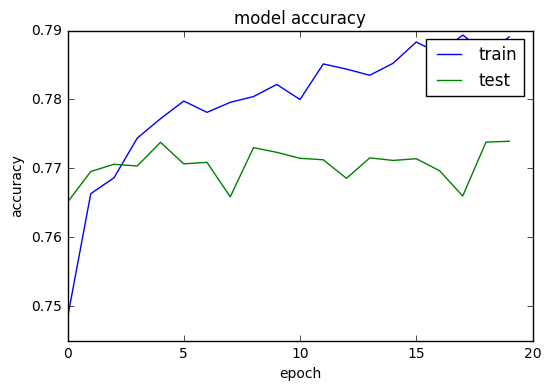

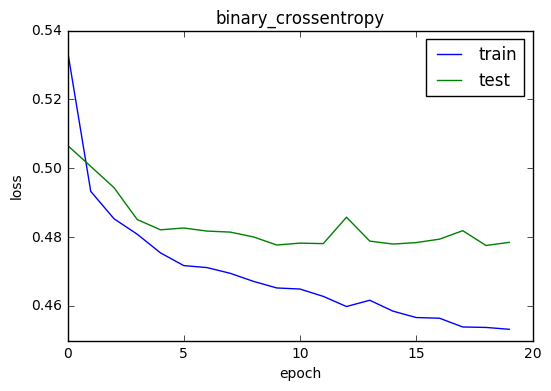

In [20]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('deep_3layers_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('binary_crossentropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('deep_3layers_loss.png')
plt.show()

In [19]:
n1 = 40
n2 = 80
p1 = 0.25
p2_lst = [0.45]
batch = 200
result_lst = []
for p2 in p2_lst:
    model = Sequential()
    model.add(Dense(n1, input_dim=d))
    model.add(Activation('relu'))
    model.add(Dropout(p1))
    model.add(Dense(n2))
    model.add(Activation('relu'))
    model.add(Dropout(p2))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.summary() # print a summary of the layers and weights in your model
    # use the loss 'categorical_crossentropy' for one-hot encoding the labels
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    histroy2 = model.fit(X_train, y_train, validation_split=0.5, batch_size=batch, nb_epoch=20,verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_19 (Dense)                 (None, 40)            3920        dense_input_6[0][0]              
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 40)            0           dense_19[0][0]                   
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 40)            0           activation_19[0][0]              
____________________________________________________________________________________________________
dense_20 (Dense)                 (None, 80)            3280        dropout_15[0][0]                 
___________________________________________________________________________________________

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


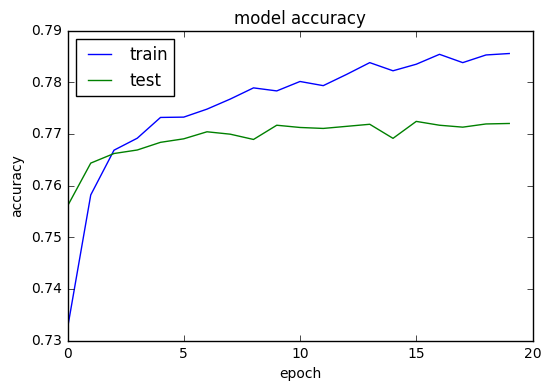

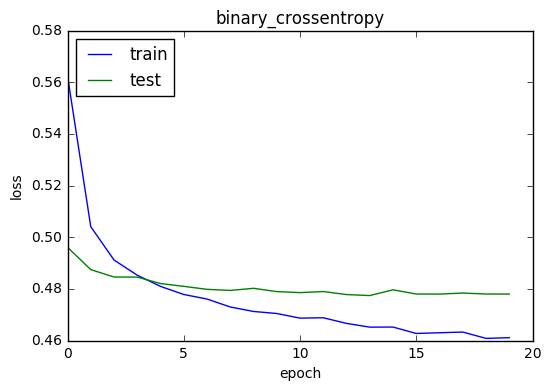

In [22]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(histroy2.history['acc'])
plt.plot(histroy2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('deep_2layers_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(histroy2.history['loss'])
plt.plot(histroy2.history['val_loss'])
plt.title('binary_crossentropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('deep_2layers_loss.png')
plt.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 1, 97, 64)     320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 6208)          0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 10)            62090       flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_17 (Dropout)             (None, 10)            0           dense_22[0][0]                   
___________________________________________________________________________________________

ValueError: Error when checking model input: expected convolution2d_input_1 to have 4 dimensions, but got array with shape (64667, 97)